In [13]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from os.path import join
import pickle as pkl
import sys
import dvu
import numpy as np
import viz
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression
import imodelsx

out = pkl.load(open('../results/acc_interpolate.pkl', 'rb'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


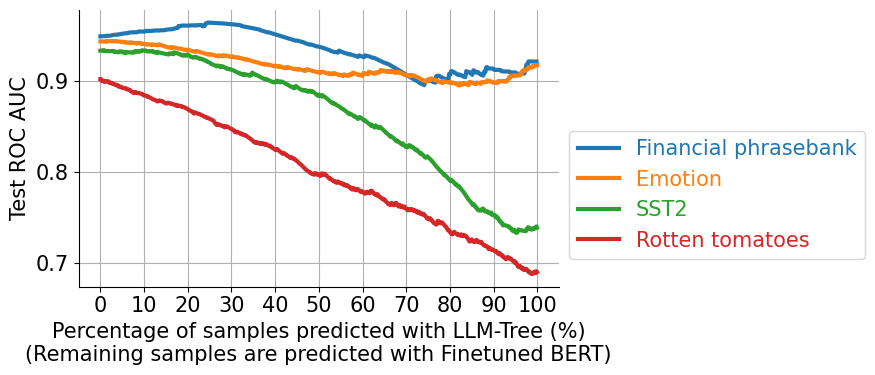

acc drops @ 50% [0.011539529833598516, 0.03376420454545448, 0.04825503073166626, 0.1055355891991594] 4.9773588577469665


In [43]:
dsets = out['dset']
acc_drops = []
plt.figure(figsize=(9, 4))
for i, dset in enumerate(dsets):
    # num_correct_combined = out['num_correct_combined'][i]
    metval = out['rocs'][i]
    n = len(metval)
    plt.plot(np.arange(n) / n * 100, metval, lw=3, label=viz.DSETS_RENAME_DICT[dset])
    drop = metval[0] - metval[n // 2]
    acc_drops.append(drop)
    plt.xlabel('Percentage of samples predicted with LLM-Tree (%)\n(Remaining samples are predicted with Finetuned BERT)')
    plt.ylabel('Test ROC AUC')
plt.xticks(np.arange(0, 101, 10))
plt.grid()    
# plt.legend(, fontsize='large') #, loc='upper left')
# dvu.line_legend()
plt.legend(bbox_to_anchor=(1, 0.6), labelcolor='linecolor')
plt.tight_layout()
plt.savefig('../results/figs/acc_interpolate.pdf', bbox_inches='tight')
plt.show()
print('acc drops @ 50%', acc_drops, 100 * np.array(acc_drops).mean())

### Try calibrating models

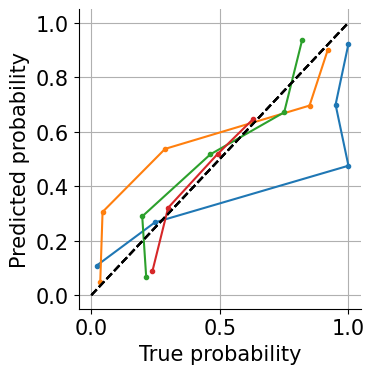

In [47]:
dsets = out['dset']
# plt.figure(figsize=(6.5, 4))
plt.figure(figsize=(4, 4))
for i, dset in enumerate(dsets):
    dset = viz.DSETS_RENAME_DICT[dset]
    preds_proba_cv = out['preds_proba_cv'][i]
    y_test = out['y_test'][i]
    y_cv = out['y_cv'][i]
    preds_proba = out['preds_proba'][i]

    lr = LogisticRegression()                                                       
    lr.fit(preds_proba_cv[:, 1].reshape(-1, 1), y_cv)     # LR needs X to be 2-dimensional
    preds_proba_cal = lr.predict_proba(preds_proba[:, 1].reshape(-1, 1))[:, 1]

    # lr = IsotonicRegression()
    # lr.fit(preds_proba_cv[:, 1], y_cv)
    # preds_proba_cal = lr.predict(preds_proba[:, 1])

    prob_true, prob_pred = calibration_curve(y_test, preds_proba[:, 1], n_bins=5)
    prob_true_cal, prob_pred_cal = calibration_curve(y_test, preds_proba_cal, n_bins=5)

    # plt.plot(prob_true, prob_pred, '.-', label=dset)
    plt.plot(prob_true_cal, prob_pred_cal, '.-', label=dset)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('True probability')
    plt.ylabel('Predicted probability')
plt.grid()

# plt.legend(bbox_to_anchor=(1.01, 0.6), fontsize='small', labelcolor='linecolor')
plt.savefig('../results/figs/calibration.pdf', bbox_inches='tight')
plt.show()